#CS4243 Project Group 19

# Notebook Setup

In [ ]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = "/content/gdrive/MyDrive/CS4243 Project/"
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/CS4243 Project/
/content/gdrive/MyDrive/CS4243 Project


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import utils
import time
from random import randint

import pylab as plt
import imageio
import os
import numpy as np
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import exposure
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cuda')

#Introduction

Mushrooms are notoriously difficult to identify, even for the seasoned trailblazers. Every year, there are thousands of mushroom poisoning cases stemming from the misidentification of mushroom species when foraging for edible mushrooms. It would thus be beneficial to devise an easy and intuitive way of identifying poisonous mushrooms to reduce risk of accidental poisoning.

<br>

The key aim of our project is to develop a mushroom identification algorithm which will have high accuracy when predicting if a mushroom is poisonous based on image data. This algorithm can then be further refined and developed into an app which foragers can use to identify different mushroom species, reducing the risk of misidentification and poisoning.

<br>

We will obtain a dataset consisting of images of poisonous and non-poisonous mushrooms by scraping the top images returned by Google Images.  Google constantly changes how Google Images returns images, which led us to conclude that running an automated web browser using [Selenium](https://www.selenium.dev/ "Selenium") was the best method for obtaining the images we needed. We will be adapting [the code implemented by Oh Yicong](https://github.com/ohyicong/Google-Image-Scraper "Oh Yicong's Google Scraper"), and adding a few novel improvements of our own.

Those improvements are
1.   Scaling parameter for downloaded images
2.   Grayscale option
3.   File type option (JPG/PNG)
4.   Fixing some minor bugs

#Dataset Development

Initially, we used the scientific name of mushrooms to scrape google images.

In [ ]:
old_poisonous_mushrooms = ["Amanita Arocheae", " Amanita Phalloides", " Amanita Ocreata", " Amanita Bisporigera", " Mycena pura", " Amanita Smithiana", \
                       "Galerina Marginata", " Paxillus Involutus", " Pleurocybella Porrigens", " Omphalotus Illudens", "  Clitocybe Rivulosa", " Conocybe Filaris", \
                       "Lepiota brunneoincarnata", " Amanita muscaria", " Ampulloclitocybe clavipes", " Chlorophyllum molybdites", " Echinoderma asperum", \
                       "Hebeloma crustuliniforme", " Hapalopilus nidulans", " Inocybe hystrix", " Inocybe rimosa", " Ramaria pallida", " Turbinellus floccosus",
                       "Pholiotina rugosa", " Omphalotus japonicus"] 

old_edible_mushrooms = ["Cantharellus cibarius", " Cantharellus enelensis", " Craterellus cornucopioides", " Cantharellus subalbidus", " Agaricus bisporus", \
                    " Agaricus arvensis", " Agaricus bernardii", " Agaricus dulcidulus", " Agaricus pattersoniae", " Pleurotus ostreatus", " Pleurotus eryngii", \
                    " Pleurotus cornucopiae", " Pleurotus pulmonarius", " Lentinula edodes", " Auricularia auricula-judae", " Phallus indusiatus", " Hericium erinaceus", \
                    " Flammulina velutipes", " Tremella fuciformis", " Cyclocybe aegerita", " Hypsizygus tessellatus", " Stropharia rugosoannulata",\
                    " Volvariella volvacea", " Calbovista", "Morchella esculenta"]

However, the images we obtained had many repeated and poor quality images. Thus we instead used more generic mushroom names. 

In [ ]:
poisonous_mushrooms = ["Death Cap mushroom", "Fool’s Webcap mushroom", "Autumn Skullcap mushroom", "Destroying Angels mushroom", \
                       "Deadly Dapperling mushroom", " False Parasol mushroom", "Ivory Funnel mushroom", "Fly agaric mushroom", \
                       "Brown Roll-Rim mushroom", "Inky Cap mushroom", "False Morel mushroom", "Elfin Saddle mushroom", \
                       "Angel Wing mushroom", " Satan’s Bolete mushroom", "Yellow Knight mushroom"]


edible_mushrooms = ["White Button mushroom", "Chanterelle mushroom", "Shiitake mushroom", "Oyster mushroom", "Enoki mushroom",\
                    "Shimeiji mushroom", "Porcini mushroom", "Morel mushroom", "Maitake mushroom", "Beech mushroom", "Hedgehog mushroom",\
                    "Sulphur Shelf mushroom", "Gyromitra mushroom", "Puffball mushroom", "Lion’s Mane mushroom"]

We obtained 50 images of each mushroom type as any more additional images would become increasingly irrelevant.

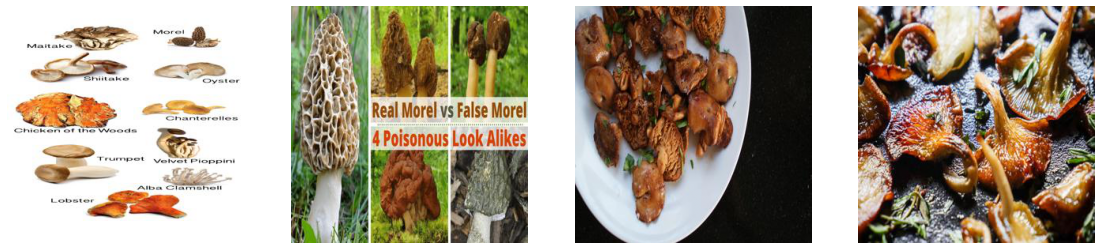

In [ ]:
diagram_mush1 = path_to_file + "/photos/Edible Mushroom - before picking/wild Shimeiji mushroom/wildShimeijimushroom47.jpeg"
diagram_mush2 = path_to_file + "/photos/Poisonous Mushroom - before picking/False Morel mushroom/FalseMorelmushroom11.jpeg"
food_mush1 = path_to_file + "/photos/Edible Mushroom - before picking/wild Hedgehog mushroom/wildHedgehogmushroom7.jpeg"
food_mush2 = path_to_file + "/photos/Edible Mushroom - before picking/wild Oyster mushroom/wildOystermushroom43.jpeg"
bad_mushrooms = [diagram_mush1, diagram_mush2, food_mush1, food_mush2]

plt.figure(figsize=(50,15))
for k in range(len(bad_mushrooms)):
    im = imageio.imread(bad_mushrooms[k]).astype(float)
    plt.subplot(2,10, k+1)
    plt.imshow((im/255.))
    plt.axis("off")

However, we receieved many pictures of diagrams, and for the edible mushrooms, we even received images of food.

Thus for edible mushrooms, we prepended the word "wild" to it. This lowers the chance of food images being returned. 

We also decided to handpick the best images from the scraper, as we felt like that was the best way to remove the noise generated from random search results.

In [ ]:
poisonous_mushrooms = ["Death Cap mushroom", "Fool’s Webcap mushroom", "Autumn Skullcap mushroom", "Destroying Angels mushroom", \
                       "Deadly Dapperling mushroom", " False Parasol mushroom", "Ivory Funnel mushroom", "Fly agaric mushroom", \
                       "Brown Roll-Rim mushroom", "Inky Cap mushroom", "False Morel mushroom", " Elfin Saddle mushroom", \
                       "Angel Wing mushroom", " Satan’s Bolete mushroom", "Yellow Knight mushroom"]


edible_mushrooms = ["wild White Button mushroom", "wild Chanterelle mushroom", "wild Shiitake mushroom", "wild Oyster mushroom", "wild Enoki mushroom",\
                    "wild Shimeiji mushroom", "wild Porcini mushroom", "wild Morel mushroom", "wild Maitake mushroom", "wild Beech mushroom", "wild Hedgehog mushroom",\
                    "wild Sulphur Shelf mushroom", "wild Gyromitra mushroom", "wild Puffball mushroom", "wild Lion’s Mane mushroom"]

##Loading Handpicked Final Dataset

In [ ]:
mushroom_dir = path_to_file + "/photos/Renamed Mushroom/"
mushroom_csv = path_to_file + "/photos/mushroom_labels.csv"

all_img = []
for i in range(len(os.listdir(mushroom_dir))):
    all_img.append("Mushroom"+str(i+1)+".jpeg")

mushroom_labels = pd.read_csv(mushroom_csv)
num_img = len(all_img)

In [ ]:
#adding a class to indicate type of mushroom
classes = []
for i in range(0, num_img):
  classes.append(i//30)
mushroom_labels["Class"] = classes

In [ ]:
print(mushroom_labels)
poison_indices = mushroom_labels["Poisonous"]
species_indices = mushroom_labels["Class"]

     Unnamed: 0 New Filename                Mushroom  Poisonous  Class
0             0    Mushroom1          Beech mushroom          0      0
1             1    Mushroom2          Beech mushroom          0      0
2             2    Mushroom3          Beech mushroom          0      0
3             3    Mushroom4          Beech mushroom          0      0
4             4    Mushroom5          Beech mushroom          0      0
..          ...          ...                     ...        ...    ...
895         895  Mushroom896  Yellow Knight mushroom          1     29
896         896  Mushroom897  Yellow Knight mushroom          1     29
897         897  Mushroom898  Yellow Knight mushroom          1     29
898         898  Mushroom899  Yellow Knight mushroom          1     29
899         899  Mushroom900  Yellow Knight mushroom          1     29

[900 rows x 5 columns]


##Mushroom Analysis

In [ ]:
#averaging last channel to create a grayscale image
img_array = np.zeros((num_img, 300, 300))
for k in range(num_img):
    im = imageio.imread(os.path.join(mushroom_dir, all_img[k])).astype(float)
    im = np.mean(im, axis=2) # average the last channel
    img_array[k,:,:] = im

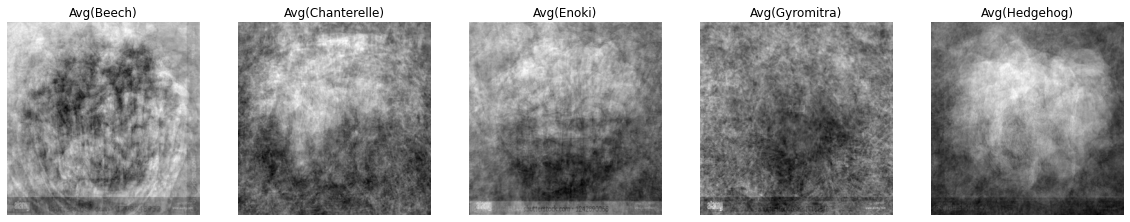

In [ ]:
# Average mushroom of different class
plt.figure(figsize=(20,12))
for i in range(5):
    plt.subplot(2,5,i+1)
    edible1 = mushroom_labels["Class"][:num_img] == i
    plt.imshow(np.mean(img_array[edible1,:,:], axis=0), cmap="gray")
    plt.axis("off")
    plt.title("Avg(" + mushroom_labels[mushroom_labels.Class == i].Mushroom.iloc[0].split()[0] + ")")

Mushrooms of different classes have somewhat of an identifiable difference between each other.

Text(0.5, 1.0, 'Avg(Poisonous)')

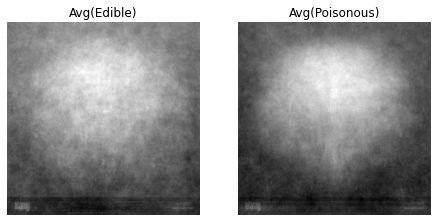

In [ ]:
plt.figure(figsize=(20,12))

# Average mushroom
plt.subplot(2,5,1)
edible = mushroom_labels["Poisonous"][:num_img] == 0
plt.imshow(np.mean(img_array[edible,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Edible)")

plt.subplot(2,5,2)
poisonous = mushroom_labels["Poisonous"][:num_img] == 1
plt.imshow(np.mean(img_array[poisonous,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Poisonous)")

However after averaging every edible and poisonous mushroom, it would seem that our images do not form a clear template to differentiate between toxicity.

In addition, there is a bar at the bottom of images created by the watermark from certain image hosting websites. We will crop the bottom rows of the image in order to remove this bar to further clean the images.

##Loading and Cropping Images

In [ ]:
# loading images
im_length = 100
img_array = np.zeros((num_img, im_length, im_length, 3))

print(num_img)

for k in range(num_img):
    if (k % 100 == 0):
        print("Currently on image "+str(k+1))
    im = imageio.imread(os.path.join(mushroom_dir, all_img[k])).astype(float)

    # Cropping bottom
    im = im[:-30]
    im = resize(im, (im_length, im_length))
    img_array[k,:,:] = im


# we should get a 900 x 100 x 100 x 3
print(img_array.shape)

900
Currently on image 1
Currently on image 101
Currently on image 201
Currently on image 301
Currently on image 401
Currently on image 501
Currently on image 601
Currently on image 701
Currently on image 801
(900, 100, 100, 3)


#MLP

In [ ]:
# defining MLP functions

def eval_on_test_set():
    running_error=0
    num_batches=0

    data = test_data
    labels = poison_test_labels
    labels = labels.to(device)

    inputs = data.reshape(-1,im_length*im_length*3).float()
    inputs = inputs.to(device)
    scores=net( inputs ) 
    predicted_labels = scores.argmax(dim=1)

    indicator = (predicted_labels == labels)
    error = indicator.sum()

    total_error = (len(data) - error)/len(data)
    test_error = total_error.item()*100
  
    return(test_error)

class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(three_layer_net , self).__init__()
        
        self.layer1 = nn.Linear(input_size, hidden_size1, bias=False)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3, bias=False)
        self.layer4 = nn.Linear(hidden_size3, output_size, bias=False)
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)

        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)

        a       = self.layer3(z_hat)
        a_hat   = torch.relu(a)
        
        scores  = self.layer4(a_hat)

        return scores

After tuning the hyperparameters, we determined the optimal values.

Hidden Layers: 1000, 250, 30, 2.

Number of Epochs: 60

Weight Decay: 0.01

Batch Size: 30

Learning Rate: 0.00001

A major breakthrough for us was the learning rate. Previous larger learning rates (>0.0001) made the MLP unable to converge, and also made the training and testing loss very erratic, which can be seen below. (note that only first and last epochs are printed)

Epoch= 0 	 Time= 0.7121071815490723 	 Training Loss= 146.417174577713 	 Training Error= 48.51851485393666 %
Test Error: 44.44444477558136 %
Epoch= 59 	 Time= 18.71380639076233 	 Training Loss= 0.3543136152956221 	 Training Error= 16.419748685978078 %
Test Error: 36.666667461395264 %


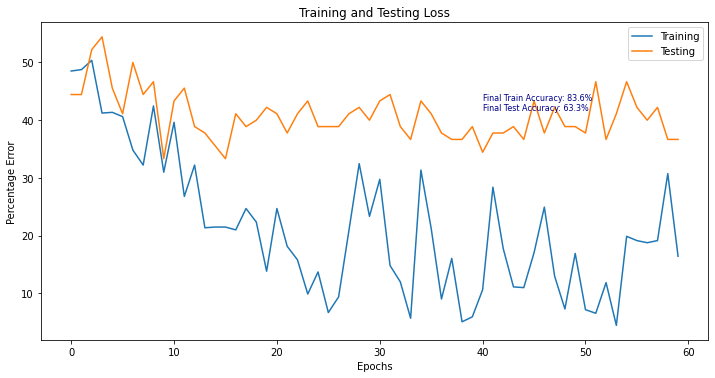

In [ ]:
shuffled = torch.randperm(900)
all_data = torch.tensor(img_array)
poison_labels = torch.tensor(poison_indices.array)

test_data = all_data[shuffled[810:]]
poison_test_labels = poison_labels[shuffled[810:]]

train_data = all_data[shuffled[:810]]
poison_train_labels = poison_labels[shuffled[:810]]

start = time.time()
num_train_img = len(train_data)
num_iter = 60
train_error_hist = []
test_error_hist = []

net=three_layer_net(3*im_length*im_length, 1000, 250, 30, 2)
net = net.to(device)
# Loss function
criterion = nn.CrossEntropyLoss()
# Learning rate
lr = 0.001
# we add a small L2 penalty in the optimizer
optimizer=torch.optim.Adam(net.parameters() , lr=lr, weight_decay=0.01)
# Mini-batch size
bs=30

for epoch in range(num_iter):
    running_loss = 0
    running_error = 0
    num_batches = 0

    shuffled_indices = torch.randperm(num_train_img)

    for count in range(0, num_train_img, bs):

        # forward and backward pass
        optimizer.zero_grad()
        
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label = poison_train_labels[indices]
        minibatch_label = minibatch_label.type(torch.LongTensor)

        # Use GPU
        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        inputs = minibatch_data.reshape(bs,im_length*im_length*3).float()

        inputs.requires_grad_()
        scores=net( inputs ) 
        loss =  criterion( scores , minibatch_label) 
        loss.backward()
        optimizer.step()
        
        # compute some stats     
        running_loss += loss.detach().item()
              
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1

    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    train_error = total_error * 100
    elapsed_time = time.time() - start
    test_error = eval_on_test_set()

    if epoch % (num_iter-1) == 0:
        print('Epoch=',epoch, '\t Time=', elapsed_time,
              '\t Training Loss=', total_loss , '\t Training Error=', train_error ,'%')
        print("Test Error: " + str(test_error) + " %")
    
    train_error_hist.append(train_error)
    test_error_hist.append(test_error)

num_variations = 1
text_height = [-5]
fig, axs = plt.subplots(num_variations, figsize=(10,5))
fig.tight_layout()
for i in range(num_variations):
    axs.plot(train_error_hist, label = "Training")
    axs.plot(test_error_hist, label = "Testing")
    axs.annotate(f"Final Train Accuracy: {(100-train_error_hist[num_iter-1]):2.1f}% \nFinal Test Accuracy: {(100-test_error_hist[num_iter-1]):2.1f}%", xy=(40,test_error_hist[num_iter-1]-text_height[i]), fontsize=8, color='darkblue')
    axs.set_title("Training and Testing Loss")
    axs.set_xlabel("Epochs")
    axs.set_ylabel("Percentage Error")
    axs.legend()

This was resolved by slowly decreasing the learning rate, and also halving it every 10 epochs.

##Train Test Loop

In [ ]:
shuffled = torch.randperm(900)
all_data = torch.tensor(img_array)
poison_labels = torch.tensor(poison_indices.array)

#generate k folds first
k_folds_data = []
k_folds_labels = []
for k in range(10):
  indices = shuffled[k*90:k*90 + 90]
  k_folds_data.append(all_data[indices]) 
  k_folds_labels.append(poison_labels[indices])

total_acc = 0

#training loop
for k in range(10):
    print("====")
    print("Now on "+str(k+1)+"th fold.")
    #get test, train data
    test_data = k_folds_data[k]
    poison_test_labels = k_folds_labels[k]

    if k == 0:
        train_data = torch.concat(k_folds_data[k+1:])
        poison_train_labels = torch.concat(k_folds_labels[k+1:])
    elif k == 9:
        train_data = torch.concat(k_folds_data[0:k])
        poison_train_labels = torch.concat(k_folds_labels[0:k])
    else:
        first_half = torch.concat(k_folds_data[0:k])
        second_half = torch.concat(k_folds_data[k+1:])
        train_data = torch.concat((first_half, second_half), dim=0)

        first_half = torch.concat(k_folds_labels[0:k])
        second_half = torch.concat(k_folds_labels[k+1:])
        poison_train_labels = torch.concat((first_half, second_half), dim=0)

    start = time.time()
    num_train_img = len(train_data)
    num_iter = 60
    train_error_hist = []
    test_error_hist = []

    net=three_layer_net(3*im_length*im_length, 1000, 250, 30, 2)
    net = net.to(device)
    # Loss function
    criterion = nn.CrossEntropyLoss()
    # Learning rate
    lr = 0.00001
    # we add a small L2 penalty in the optimizer
    optimizer=torch.optim.Adam(net.parameters() , lr=lr, weight_decay=0.01)
    # Mini-batch size
    bs=30

    for epoch in range(num_iter):
        running_loss = 0
        running_error = 0
        num_batches = 0

        shuffled_indices = torch.randperm(num_train_img)

        for count in range(0, num_train_img, bs):

            # forward and backward pass
            optimizer.zero_grad()
            
            indices=shuffled_indices[count:count+bs]
            minibatch_data =  train_data[indices]
            minibatch_label = poison_train_labels[indices]
            minibatch_label = minibatch_label.type(torch.LongTensor)

            # Use GPU
            minibatch_data = minibatch_data.to(device)
            minibatch_label = minibatch_label.to(device)

            inputs = minibatch_data.reshape(bs,im_length*im_length*3).float()

            inputs.requires_grad_()
            scores=net( inputs ) 
            loss =  criterion( scores , minibatch_label) 
            loss.backward()
            optimizer.step()
            
            # compute some stats     
            running_loss += loss.detach().item()
                  
            error = utils.get_error( scores.detach() , minibatch_label)
            running_error += error.item()
            
            num_batches+=1

        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        train_error = total_error * 100
        elapsed_time = time.time() - start
        test_error = eval_on_test_set()

        if epoch % 10 == 0 : 
            lr = lr/2
            print(' ')
        if epoch % (num_iter-1) == 0:
            print('Epoch=',epoch, '\t Time=', elapsed_time,
                  '\t Training Loss=', total_loss , '\t Training Error=', train_error ,'%')
            print("Test Error: " + str(test_error) + " %")
        
        train_error_hist.append(train_error)
        test_error_hist.append(test_error)

    total_acc += 100 - test_error
print("Average accuracy is "+str(total_acc/10)+"%")

====
Now on 1th fold.
 
Epoch= 0 	 Time= 0.5201258659362793 	 Training Loss= 1.8052132769867226 	 Training Error= 45.80246541235182 %
Test Error: 41.111111640930176 %
 
 
 
 
 
Epoch= 59 	 Time= 18.233182191848755 	 Training Loss= 0.028270178957393876 	 Training Error= 0.6172833619294343 %
Test Error: 32.22222328186035 %
====
Now on 2th fold.
 
Epoch= 0 	 Time= 0.5128443241119385 	 Training Loss= 2.4920266425168074 	 Training Error= 50.37036714730439 %
Test Error: 44.44444477558136 %
 
 
 
 
 
Epoch= 59 	 Time= 18.337430238723755 	 Training Loss= 0.02575100539252162 	 Training Error= 0.9876533790870948 %
Test Error: 37.77777850627899 %
====
Now on 3th fold.
 
Epoch= 0 	 Time= 0.5143322944641113 	 Training Loss= 0.976811099935461 	 Training Error= 47.16049123693396 %
Test Error: 43.33333373069763 %
 
 
 
 
 
Epoch= 59 	 Time= 18.128608465194702 	 Training Loss= 0.02509528319178908 	 Training Error= 0.8641967067012081 %
Test Error: 35.555556416511536 %
====
Now on 4th fold.
 
Epoch= 0 	 

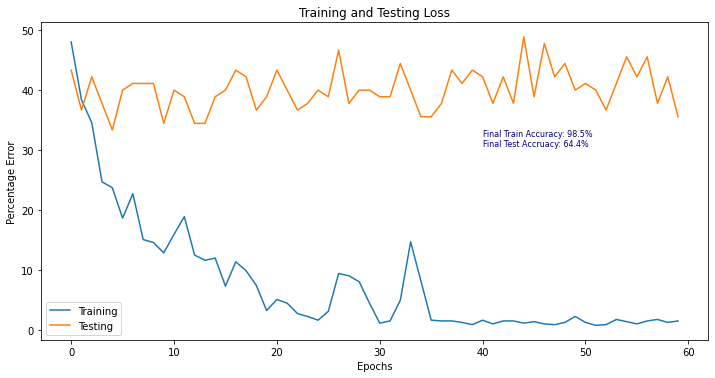

In [ ]:
num_variations = 1
text_height = [5]
fig, axs = plt.subplots(num_variations, figsize=(10,5))
fig.tight_layout()
for i in range(num_variations):
    axs.plot(train_error_hist, label = "Training")
    axs.plot(test_error_hist, label = "Testing")
    axs.annotate(f"Final Train Accuracy: {(100-train_error_hist[num_iter-1]):2.1f}% \nFinal Test Accruacy: {(100-test_error_hist[num_iter-1]):2.1f}%", xy=(40,test_error_hist[num_iter-1]-text_height[i]), fontsize=8, color='darkblue')
    axs.set_title("Training and Testing Loss")
    axs.set_xlabel("Epochs")
    axs.set_ylabel("Percentage Error")
    axs.legend()

A much smoother training graph can be observed.

We also used 10-fold cross validation to give us an overall accuracy of 64.4%.

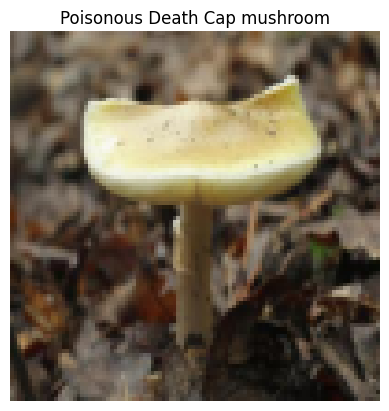

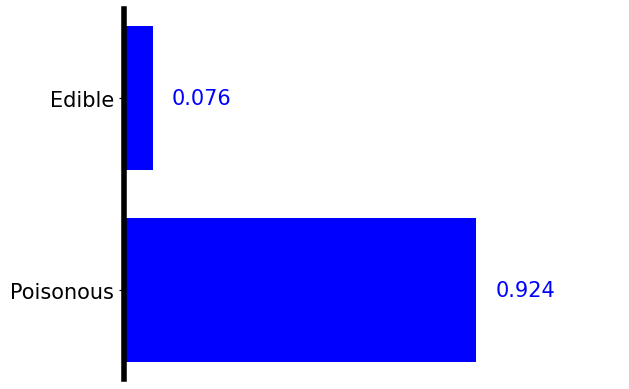

In [ ]:
#load and show image
mush_num = indices[np.random.randint(0,len(indices))].item()
mush_name = mushroom_labels[mushroom_labels.Class == species_indices.iloc[mush_num]].iloc[0].Mushroom
is_poisonous = poison_indices.iloc[mush_num]
labels = ['Edible', 'Poisonous']
im = img_array[mush_num]
plt.imshow((im/255.))
plt.axis("off")
plt.title(labels[is_poisonous] + " " + mush_name)

#get mushroom score
test = torch.Tensor(im.reshape(1,im_length*im_length*3)).to(device)
probs= torch.softmax(net(test), dim=1)

#show probability
utils.show_prob_mush_mlp(probs)

#CNN

##Different Datasets

For the CNN we experimented with different augmentation methods to datasets to see their effects on the models.

In [ ]:
mushroom_dir = path_to_file + "/photos/Renamed Mushroom/"
mushroom_csv = path_to_file + "/photos/mushroom_labels.csv"

all_img = []
for i in range(len(os.listdir(mushroom_dir))):
    all_img.append("Mushroom"+str(i+1)+".jpeg")

mushroom_labels = pd.read_csv(mushroom_csv)

mushroom_labels

,Unnamed: 0,New Filename,Mushroom,Poisonous
0,0,Mushroom1,Beech mushroom,0
1,1,Mushroom2,Beech mushroom,0
2,2,Mushroom3,Beech mushroom,0
3,3,Mushroom4,Beech mushroom,0
4,4,Mushroom5,Beech mushroom,0
...,...,...,...,...
895,895,Mushroom896,Yellow Knight mushroom,1
896,896,Mushroom897,Yellow Knight mushroom,1
897,897,Mushroom898,Yellow Knight mushroom,1
898,898,Mushroom899,Yellow Knight mushroom,1


In [ ]:
classes = []
for i in range(0, 900):
  classes.append(i//30)
mushroom_labels["Class"] = classes

###Dataset 1

We can test the effects of different datasets on the performance of the models. 

In this first set, we average the colour channels to obtain a 2d image array

In [ ]:
from torchvision import transforms
# loading images
# we use 100 * 100 to reduce memory consumption
im_length = 100
num_img = len(all_img)
num_img2 = num_img*2
img_array = np.zeros((num_img2, im_length, im_length))

for k in range(num_img):
    if (k % 100 == 0):
        print("Currently on image "+str(k+1))
    im = imageio.imread(os.path.join(mushroom_dir, all_img[k])).astype(float)

    # Cropping bottom
    im = im[:-30]

    # increase constrast 
    im = exposure.rescale_intensity(im)*255
    im = resize(im, (im_length, im_length))  
    im = np.mean(im, axis=2)
    img_array[k,:,:] = im

    # appending mirror image
    flipped = np.fliplr(im) # mirror image
    img_array[(k+num_img),:,:] = flipped

# we should get a 1800 x 100 x 100
print(img_array.shape)

Currently on image 1
Currently on image 101
Currently on image 201
Currently on image 301
Currently on image 401
Currently on image 501
Currently on image 601
Currently on image 701
Currently on image 801
(1800, 100, 100)


In [ ]:
mushroom_labels2 = pd.concat([mushroom_labels, mushroom_labels])
mushroom_labels_final = mushroom_labels2.drop(mushroom_labels2.columns[[0,1,2]], axis=1)

poison_indices = mushroom_labels_final["Poisonous"]

print(len(poison_indices))

1800


###Dataset 2

However, colour is an important feature when humans identify mushrooms. Similarly, we think that the colour channels may help the machine classify better. Hence we experiment with 3d images arrays.

In [ ]:
# loading images
# we use 100 * 100 to reduce memory consumption
im_length = 100
num_img = len(all_img)
num_img2 = num_img*2
img_array2 = np.zeros((num_img2, im_length, im_length, 3))

print(num_img)

for k in range(num_img):
    if (k % 100 == 0):
        print("Currently on image "+str(k+1))
    im = imageio.imread(os.path.join(mushroom_dir, all_img[k])).astype(float)

    # Cropping bottom
    im = im[:-30]

    # increase constrast 
    im = exposure.rescale_intensity(im)*255

    im = resize(im, (im_length, im_length))
    img_array2[k,:,:] = im

    # appending mirror image
    flipped = np.fliplr(im) # mirror image
    img_array2[(k+num_img),:,:] = flipped

# we should get a 1800 x 100 x 100 x 3
print(img_array2.shape)

900
Currently on image 1
Currently on image 101
Currently on image 201
Currently on image 301
Currently on image 401
Currently on image 501
Currently on image 601
Currently on image 701
Currently on image 801
(1800, 100, 100, 3)


In [ ]:
mushroom_labels2 = pd.concat([mushroom_labels, mushroom_labels])
mushroom_labels_final = mushroom_labels2.drop(mushroom_labels2.columns[[0,1,2]], axis=1)

poison_indices2 = mushroom_labels_final["Poisonous"]

print(len(poison_indices2))

1800


###Dataset 3

CNN works by shifting a filter across the image to find the area of highest activation which will then tell the network that the input image contains the patten represented by the filter. However, this works best if the filter is approximately the same size as the pattern in the image. 

<br>

From the examples below, we can observe that mushrooms in the same class of images can be differently sized and that will affect the prediction of the network since these differently sized mushrooms may not produce high activation maps.

(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


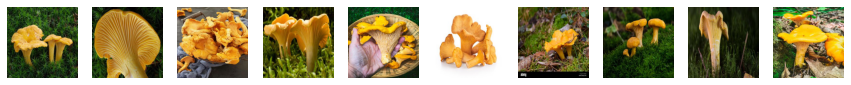

In [ ]:
plt.figure(figsize=(15,3))

for k in range(10):
    #load image
    im = imageio.imread(os.path.join(mushroom_dir, all_img[k+30])).astype(float)
    print(im.shape)
    
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10, k+1)
    plt.imshow((im/255.))
    plt.axis("off")

To combat this, we can introduce images of different scales into the dataset. 

In [ ]:
# loading images

im_length = 64
num_img = len(all_img)

#introduce 3 scales for each image + mirror flip 
num_img2 = num_img*2*3
img_array3 = np.zeros((num_img2, im_length, im_length))

print(num_img)

for k in range(num_img):
    if (k % 100 == 0):
        print("Currently on image "+str(k+1))
    im = imageio.imread(os.path.join(mushroom_dir, all_img[k])).astype(float)

    # Cropping bottom
    im = im[:-30]

    # increase constrast 
    im = exposure.rescale_intensity(im)*255

    #scale images to 2 other different sizes by padding
    #pad 5 rows top/bottom and pad 10 rows top/bottom
    im1 = np.pad(im, ((5, 5), (5, 5), (0, 0)))
    im2 = np.pad(im,((10, 10), (10, 10), (0, 0)))

    im = resize(im, (im_length, im_length))
    im1 = resize(im1, (im_length, im_length))
    im2 = resize(im2, (im_length, im_length))

    im = np.mean(im, axis=2)
    im1 = np.mean(im1, axis=2)
    im2 = np.mean(im2, axis=2)

    img_array3[k,:,:] = im
    img_array3[k+num_img,:,:] = im1
    img_array3[k+num_img,:,:] = im2

    # appending mirror image
    flipped = np.fliplr(im) # mirror image
    flipped1 = np.fliplr(im1)
    flipped2 = np.fliplr(im2)
    img_array3[(k+num_img*3),:,:] = flipped
    img_array3[(k+num_img*4),:,:] = flipped1
    img_array3[(k+num_img*5),:,:] = flipped2

# we should get a 5400 x 64 x 64
print(img_array3.shape)

900
Currently on image 1
Currently on image 101
Currently on image 201
Currently on image 301
Currently on image 401
Currently on image 501
Currently on image 601
Currently on image 701
Currently on image 801
(5400, 64, 64)


In [ ]:
#concat 5 times
mushroom_labels2 = pd.concat([mushroom_labels, mushroom_labels])
mushroom_labels2 = pd.concat([mushroom_labels2, mushroom_labels])
mushroom_labels2 = pd.concat([mushroom_labels2, mushroom_labels])
mushroom_labels2 = pd.concat([mushroom_labels2, mushroom_labels])
mushroom_labels2 = pd.concat([mushroom_labels2, mushroom_labels])
mushroom_labels2 = mushroom_labels2.reset_index()

mushroom_labels_final = mushroom_labels2.drop(mushroom_labels2.columns[[0,1,2]], axis=1)

poison_indices3 = mushroom_labels_final["Poisonous"]

print(len(poison_indices3))

5400


##Models

We also compare the performances of 2 different architectures - vanilla CNN and VGG as well as their 3d counterparts for the dataset with colour channels

###Vanilla CNN

In [ ]:
class vanillaCNN(nn.Module):
  def __init__(self):
    super(vanillaCNN, self).__init__()

    #100 x 100 -> 50 x 100 x 100
    self.conv1 = nn.Conv2d(1, 50, kernel_size=3, padding=1)

    #50x100x100 -> 50x50x50
    self.pool1 = nn.MaxPool2d(2, 2)

    #50 x 50 x 50 -> 100 x 50 x 50
    self.conv2 = nn.Conv2d(50, 100, kernel_size=3, padding=1)
    
    #100x50x50 -> 100x25x25
    self.pool2 = nn.MaxPool2d(2, 2)

    #100 x 25 x 25 -> 150 x 25 x 25
    self.conv3 = nn.Conv2d(100, 150, kernel_size=3, padding=1)

    #150x25x25 -> 150x5x5
    self.pool3 = nn.MaxPool2d(5, 5)

    #150x5x5 -> 3750 -> 1875
    self.linear1 = nn.Linear(3750, 1875)

    #1875 -> 30
    self.linear2 = nn.Linear(1875, 30)

    #30 -> 2
    self.linear3 = nn.Linear(30, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = torch.relu(x)
    x = self.pool3(x)
      
    x = x.view(-1, 3750)
    x = self.linear1(x)
    x = torch.relu(x)

    x = self.linear2(x)
    x = torch.relu(x)

    x = self.linear3(x)


    return x

**3D Vanilla CNN**

In [ ]:
class vanillaCNN3d(nn.Module):
  def __init__(self):
    super(vanillaCNN3d, self).__init__()

    #100 x 100 -> 50 x 100 x 100
    self.conv1 = nn.Conv3d(1, 50, kernel_size=3, padding=1)

    #50x100x100 -> 50x50x50
    self.pool1 = nn.MaxPool3d((2, 2, 1))

    #50 x 50 x 50 -> 100 x 50 x 50
    self.conv2 = nn.Conv3d(50, 100, kernel_size=3, padding=1)
    
    #50x50x50 -> 100x25x25
    self.pool2 = nn.MaxPool3d((2, 2, 1))

    #100 x 25 x 25 -> 150 x 25 x 25
    self.conv3 = nn.Conv3d(100, 150, kernel_size=3, padding=1)

    #150x25x25 -> 150x5x5
    self.pool3 = nn.MaxPool3d((5, 5, 3))

    #150x5x5 -> 3750 -> 1875
    self.linear1 = nn.Linear(3750, 1875)

    #1875 -> 30
    self.linear2 = nn.Linear(1875, 30)

    #30 -> 2
    self.linear3 = nn.Linear(30, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = torch.relu(x)
    x = self.pool3(x)
      
    x = x.view(-1, 3750)
    x = self.linear1(x)
    x = torch.relu(x)

    x = self.linear2(x)
    x = torch.relu(x)

    x = self.linear3(x)


    return x

Vanilla CNN for Dataset 3

In [ ]:
class kvanillaCNN(nn.Module):
  def __init__(self):
    super(kvanillaCNN, self).__init__()

    #64 x 64 -> 50 x 64 x 64
    self.conv1 = nn.Conv2d(1, 50, kernel_size=3, padding=1)

    #50x64x64 -> 50x32x32
    self.pool1 = nn.MaxPool2d(2, 2)

    #50 x 32 x 32 -> 100 x 32 x 32
    self.conv2 = nn.Conv2d(50, 100, kernel_size=3, padding=1)
    
    #100x32x32 -> 100x16x16
    self.pool2 = nn.MaxPool2d(2, 2)

    #100 x 16 x 16 -> 150 x 16 x 16
    self.conv3 = nn.Conv2d(100, 150, kernel_size=3, padding=1)

    #150x16x16 -> 150x8x8
    self.pool3 = nn.MaxPool2d(2, 2)

    #150x8x8 -> 9600 -> 4800
    self.linear1 = nn.Linear(9600, 4800)

    #4800 -> 30
    self.linear2 = nn.Linear(4800, 30)

    #30 -> 2
    self.linear3 = nn.Linear(30, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = torch.relu(x)
    x = self.pool3(x)
      
    x = x.view(-1, 9600)
    x = self.linear1(x)
    x = torch.relu(x)

    x = self.linear2(x)
    x = torch.relu(x)

    x = self.linear3(x)


    return x

###VGG

In [ ]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         1 x 100 x 100 -> 50 x 100 x 100 -> 50 x 50 x 50   
        self.conv1a = nn.Conv2d(1, 50,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(50, 50,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2, 2)

        # block 2:         50 x 50 x 50 --> 100 x 50 x 50 -> 100 x 25 x 25
        self.conv2a = nn.Conv2d(50,  100, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(100, 100, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         100 x 25 x 25 --> 256 x 25 x 25 -> 256 x 5 x 5
        self.conv3a = nn.Conv2d(100, 150, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(150, 256, kernel_size=3, padding=1 )
        self.conv3c = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(5,5)
       
        #256 x 5 x 5 -> 6400 -> 2000 -> 30 -> 2
        self.linear1 = nn.Linear(6400, 2000)
        self.linear2 = nn.Linear(2000, 30)
        self.linear3 = nn.Linear(30, 2)

    def forward(self, x):

        # block 1:         
        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)

        # block 2:         
        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)

        # block 3:         
        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.conv3c(x)
        x = torch.relu(x)
        x = self.pool3(x)

        # linear layers:   
        x = x.view(-1, 6400)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

3D VGG

In [ ]:
class VGG_convnet3d(nn.Module):

    def __init__(self):

        super(VGG_convnet3d, self).__init__()

        # block 1:         1 x 100 x 100 -> 64 x 100 x 100 -> 64 x 50 x 50   
        self.conv1a = nn.Conv3d(1,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv3d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool3d((2, 2, 1))

        # block 2:         64 x 50 x 50 --> 128 x 50 x 50 -> 128 x 25 x 25
        self.conv2a = nn.Conv3d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv3d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool3d((2,2,1))

        # block 3:         128 x 25 x 25 --> 256 x 25 x 25 -> 256 x 5 x 5    
        self.conv3a = nn.Conv3d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv3d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool3d((5,5,3))

        self.linear1 = nn.Linear(6400, 3200)
        self.linear2 = nn.Linear(3200, 2)

    def forward(self, x):

        # block 1:       
        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)

        # block 2:         
        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)

        # block 3:         
        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        # linear layers:   
        x = x.view(-1, 6400)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        
        return x

VGG for dataset 3

In [ ]:
class KVGG_convnet(nn.Module):

    def __init__(self):

        super(KVGG_convnet, self).__init__()

        # block 1:         1 x 64 x 64 -> 50 x 64 x 64 -> 50 x 32 x 32   
        self.conv1a = nn.Conv2d(1, 50,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(50, 50,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2, 2)

        # block 2:         50 x 32 x 32 --> 100 x 32 x 32 -> 100 x 16 x 16
        self.conv2a = nn.Conv2d(50,  100, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(100, 100, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         100 x 16 x 16 --> 256 x 16 x 16 -> 256 x 4 x 4
        self.conv3a = nn.Conv2d(100, 150, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(150, 256, kernel_size=3, padding=1 )
        self.conv3c = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(4,4)
       
        #256 x 4 x 4 -> 4096 -> 2000 -> 30 -> 2
        self.linear1 = nn.Linear(4096, 2000)
        self.linear2 = nn.Linear(2000, 30)
        self.linear3 = nn.Linear(30, 2)

    def forward(self, x):

        # block 1:         
        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)

        # block 2:         
        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)

        # block 3:         
        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.conv3c(x)
        x = torch.relu(x)
        x = self.pool3(x)

        # linear layers:   
        x = x.view(-1, 4096)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

##Define necessary functions

We first experiment using the train-test split method to evaluate the models.

In [ ]:
def train_test_split(data_arr, label_arr, trainp, size):
  shuffled = torch.randperm(size)
  all_data = torch.tensor(data_arr)

  train = int(trainp * size)
  test = size - trainp

  train_indices = shuffled[0:train]
  test_indices = shuffled[train:]

  train_data = all_data[train_indices]
  test_data = all_data[test_indices]

  all_labels = torch.tensor(label_arr.array)
  train_labels = all_labels[train_indices]
  test_labels = all_labels[train_indices]

  return train_data, train_labels, test_data, test_labels


def train(epochs, model, train_data, train_labels, bs, lr, data_len, decay=True):
  train_error_hist = []

  mean= train_data.mean()
  mean=mean.to(device)

  std= train_data.std()
  std=std.to(device)

  criterion = nn.CrossEntropyLoss()

  for epoch in range(0, epochs):
    if decay and not epoch%10 and epoch != 0:
          lr = lr / 1.25

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    running_loss = 0
    running_error = 0
    num_batches = 0

    shuffled_indices = torch.randperm(data_len)

    for count in range(0, data_len, bs):
      optimizer.zero_grad()
            
      indices=shuffled_indices[count:count+bs]
      minibatch_data =  train_data[indices].unsqueeze(dim=1)
      minibatch_label = train_labels[indices]

      
      minibatch_data=minibatch_data.to(device)
      minibatch_label=minibatch_label.to(device)
      
      inputs = (minibatch_data - mean)/std 
      
      inputs.requires_grad_()
      
      #forward pass
      scores = model( inputs.float() ) 

      #backward pass
      loss = criterion(scores, minibatch_label)

      loss.backward()

      optimizer.step()

      #stats
      running_loss += loss.detach().item()
        
      error = utils.get_error( scores.detach() , minibatch_label)
      running_error += error.item()
      train_error_hist.append(error)

      num_batches+=1 


    #avg stats
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    
    if not epoch%5 and epoch != 0:
      print('epoch=',epoch, '\t lr=', lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
      print(' ')

  return train_error_hist


def evaluate(t_model, batchsize, data_len, test_data, test_labels):

    running_error=0
    num_batches=0
    mean = test_data.mean()
    mean = mean.to(device)

    std = test_data.std()
    std = std.to(device)

    for i in range(0,data_len,batchsize):

        minibatch_data =  test_data[i:i+batchsize].unsqueeze(dim=1)
        minibatch_label = test_labels[i:i+batchsize]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std   

        scores = t_model( inputs.float() ) 

        error = utils.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    accuracy = (1 - total_error) * 100
    print( 'error rate on test set =', total_error*100 ,'percent')
    print('Accuracy of model = ', accuracy, '%')
    return accuracy


##Evaluation of vanilla CNN and VGG on dataset 1

In [ ]:
#split dataset
train_data, train_labels, test_data, test_labels = train_test_split(img_array, poison_indices, 0.8, 1800)

#training loop
v_model = vanillaCNN().float()
v_model = v_model.to(device)
epochs = 60
bs = 144
lr = 0.25
dlen = 1440

#train & eval vanilla CNN
v_train_error_hist = train(epochs, v_model, train_data, train_labels, bs, lr, dlen)

v_model.eval()

print("Accuracy of VanillaCNN: ", evaluate(v_model, 36, 360, test_data, test_labels))

epoch= 5 	 lr= 0.25 	 loss= 0.6806995809078217 	 error= 42.91666567325592 percent
 
epoch= 10 	 lr= 0.2 	 loss= 0.6160765528678894 	 error= 35.90277671813965 percent
 
epoch= 15 	 lr= 0.2 	 loss= 0.5968720018863678 	 error= 32.777777910232544 percent
 
epoch= 20 	 lr= 0.16 	 loss= 0.543289989233017 	 error= 28.402777910232547 percent
 
epoch= 25 	 lr= 0.16 	 loss= 0.5009002149105072 	 error= 23.819443583488464 percent
 
epoch= 30 	 lr= 0.128 	 loss= 0.49918305575847627 	 error= 25.20833194255829 percent
 
epoch= 35 	 lr= 0.128 	 loss= 0.4947140872478485 	 error= 25.90277671813965 percent
 
epoch= 40 	 lr= 0.1024 	 loss= 0.3143112748861313 	 error= 13.263887763023376 percent
 
epoch= 45 	 lr= 0.1024 	 loss= 0.41044007837772367 	 error= 19.097222089767456 percent
 
epoch= 50 	 lr= 0.08192 	 loss= 0.20167535543441772 	 error= 7.847222089767455 percent
 
epoch= 55 	 lr= 0.08192 	 loss= 0.4324094407260418 	 error= 18.472222089767456 percent
 
error rate on test set = 48.88889014720917 perce

In [ ]:
#split dataset
train_data, train_labels, test_data, test_labels = train_test_split(img_array, poison_indices, 0.8, 1800)

#training loop
vgg_model = VGG_convnet().float().to(device)
epochs = 60
bs = 144
lr = 0.12
dlen = 1440

vgg_hist = train(epochs, vgg_model, train_data, train_labels, bs, lr, dlen, decay=False)

vgg_model.eval()

print("Accuracy of VGG:", evaluate(vgg_model, 36, 360, test_data, test_labels))

epoch= 5 	 lr= 0.12 	 loss= 0.6932116389274597 	 error= 50.833333730697625 percent
 
epoch= 10 	 lr= 0.12 	 loss= 0.6932640373706818 	 error= 50.138888955116265 percent
 
epoch= 15 	 lr= 0.12 	 loss= 0.6933343052864075 	 error= 50.06944417953492 percent
 
epoch= 20 	 lr= 0.12 	 loss= 0.692959851026535 	 error= 48.819443583488464 percent
 
epoch= 25 	 lr= 0.12 	 loss= 0.6923978269100189 	 error= 43.888888359069824 percent
 
epoch= 30 	 lr= 0.12 	 loss= 0.6905604124069213 	 error= 44.444443583488464 percent
 
epoch= 35 	 lr= 0.12 	 loss= 0.6748806059360504 	 error= 38.958332538604736 percent
 
epoch= 40 	 lr= 0.12 	 loss= 0.6663014948368072 	 error= 38.958332538604736 percent
 
epoch= 45 	 lr= 0.12 	 loss= 0.6409519374370575 	 error= 37.84722149372101 percent
 
epoch= 50 	 lr= 0.12 	 loss= 0.6089457869529724 	 error= 33.749998807907104 percent
 
epoch= 55 	 lr= 0.12 	 loss= 0.5956335604190827 	 error= 32.01388716697693 percent
 
error rate on test set = 50.83333432674409 percent
Accuracy

##Evaluation of vanilla CNN and VGG on dataset 2

In [ ]:
#split dataset
train_data, train_labels, test_data, test_labels = train_test_split(img_array2, poison_indices2, 0.8, 1800)

#training loop
v_model = vanillaCNN3d().float()
v_model = v_model.to(device)
epochs = 40
bs = 144
lr = 0.25
dlen = 1440

#train & eval vanilla CNN
v_hist = train(epochs, v_model, train_data, train_labels, bs, lr, dlen)

v_model.eval()

print("Accuracy of VanillaCNN: ", evaluate(v_model, 36, 360, test_data, test_labels))

epoch= 5 	 lr= 0.25 	 loss= 0.6598949551582336 	 error= 36.874998807907104 percent
 
epoch= 10 	 lr= 0.2 	 loss= 0.6304041802883148 	 error= 37.083332538604736 percent
 
epoch= 15 	 lr= 0.2 	 loss= 0.6107580006122589 	 error= 33.47222089767456 percent
 
epoch= 20 	 lr= 0.16 	 loss= 0.5428232103586197 	 error= 27.91666626930237 percent
 
epoch= 25 	 lr= 0.16 	 loss= 0.48375439643859863 	 error= 23.472222089767456 percent
 
epoch= 30 	 lr= 0.128 	 loss= 0.39868599474430083 	 error= 17.083333134651184 percent
 
epoch= 35 	 lr= 0.128 	 loss= 0.37606299519538877 	 error= 17.916666269302368 percent
 
error rate on test set = 52.77777850627899 percent
Accuracy of model =  47.22222149372101 %
Accuracy of VanillaCNN:  47.22222149372101


In [ ]:
#split dataset
train_data, train_labels, test_data, test_labels = train_test_split(img_array2, poison_indices2, 0.8, 1800)

#training loop
epochs = 40
bs = 144
lr = 0.25
dlen = 1440

#train and eval VGG
vgg_model = VGG_convnet3d().float().to(device)

vgg_hist = train(epochs, vgg_model, train_data, train_labels, bs, lr, dlen)

vgg_model.eval()

print("Accuracy of VGG:", evaluate(vgg_model, 36, 360, test_data, test_labels))

epoch= 5 	 lr= 0.25 	 loss= 0.6940957129001617 	 error= 49.583332538604736 percent
 
epoch= 10 	 lr= 0.2 	 loss= 0.6949619174003601 	 error= 50.416666865348816 percent
 
epoch= 15 	 lr= 0.2 	 loss= 0.674509596824646 	 error= 39.652777314186096 percent
 
epoch= 20 	 lr= 0.16 	 loss= 0.7192773282527923 	 error= 50.277777910232544 percent
 
epoch= 25 	 lr= 0.16 	 loss= 0.6894339203834534 	 error= 47.70833134651184 percent
 
epoch= 30 	 lr= 0.128 	 loss= 0.6284876048564911 	 error= 33.125 percent
 
epoch= 35 	 lr= 0.128 	 loss= 0.6244527697563171 	 error= 35.06944298744202 percent
 
error rate on test set = 52.77777731418609 percent
Accuracy of model =  47.22222268581391 %
Accuracy of VGG: 47.22222268581391


Comparing across the 2 experiments, we can see that both models in both situations performed relatively similar. 

Through repeated experiments, we realised that the vanilla cnn performed the same or slightly better with the RGB dataset but the vgg almost always performed worse with the RGB as compared to grayscale. We also observed that the vgg was not converging on the data properly.

We believe this could have been due to a vanishing gradient problem and was made worse in the RGB case since it had more parameters.



##K-folds cross validation with scale jittering

Considering the fact that we only have 900 base images, we want to maximise the use of all the data for training and testing and get an unbiased estimate for the performance.

Since our problem is a binary classification, it does not require such complex representations and a smaller input size helps the network learn better representations. So we decided to scale down the input sizes from 100x100 to 64x64.

We also apply scale jittering by introducing the same images but with different scales into the dataset. We did so by padding the original images. Doing so helps increase the resistance of the model towards scale variance and reduce network saturation as it can learn representations of the pattern in different scales. 


###Vanilla CNN 10-Folds Cross Validation

In [ ]:
shuffled = torch.randperm(5400)
all_data = torch.tensor(img_array3)
poison_labels = torch.tensor(poison_indices3.array)


#generate k folds first
k_folds_data = []
k_folds_labels = []
for k in range(10):
  indices = shuffled[k*540:k*540 + 540]
  k_folds_data.append(all_data[indices]) 
  k_folds_labels.append(poison_labels[indices])

total_acc = 0

#training loop
for k in range(10):

  model = kvanillaCNN().float().to(device)

  #get test, train data
  test_data = k_folds_data[k]
  poison_test_labels = k_folds_labels[k]

  if k == 0:
    train_data = torch.concat(k_folds_data[k+1:])
    poison_train_labels = torch.concat(k_folds_labels[k+1:])
  elif k == 9:
    train_data = torch.concat(k_folds_data[0:k])
    poison_train_labels = torch.concat(k_folds_labels[0:k])
  else:
    first_half = torch.concat(k_folds_data[0:k])
    second_half = torch.concat(k_folds_data[k+1:])
    train_data = torch.concat((first_half, second_half), dim=0)

    first_half = torch.concat(k_folds_labels[0:k])
    second_half = torch.concat(k_folds_labels[k+1:])
    poison_train_labels = torch.concat((first_half, second_half), dim=0)

  model.train()

  train(40, model, train_data, poison_train_labels, 486, 0.25, 4860)

  model.eval()

  acc = evaluate(model, 54, 540, test_data, poison_test_labels)
  total_acc = total_acc + acc

print(total_acc)
print('avg accuracy = ', total_acc/10)


epoch= 5 	 lr= 0.25 	 loss= 0.6536370396614075 	 error= 39.259260296821594 percent
 
epoch= 10 	 lr= 0.2 	 loss= 0.6366854548454285 	 error= 37.32510566711426 percent
 
epoch= 15 	 lr= 0.2 	 loss= 0.6248991549015045 	 error= 35.80247223377228 percent
 
epoch= 20 	 lr= 0.16 	 loss= 0.5613742291927337 	 error= 31.234568953514096 percent
 
epoch= 25 	 lr= 0.16 	 loss= 0.5373041749000549 	 error= 28.74485731124878 percent
 
epoch= 30 	 lr= 0.128 	 loss= 0.4906651198863983 	 error= 25.082307457923893 percent
 
epoch= 35 	 lr= 0.128 	 loss= 0.4740764796733856 	 error= 25.452677607536316 percent
 
error rate on test set = 23.888887763023376 percent
Accuracy of model =  76.11111223697662 %
epoch= 5 	 lr= 0.25 	 loss= 0.6495442748069763 	 error= 39.46502208709717 percent
 
epoch= 10 	 lr= 0.2 	 loss= 0.6015324294567108 	 error= 34.93827402591705 percent
 
epoch= 15 	 lr= 0.2 	 loss= 0.585897296667099 	 error= 32.3045289516449 percent
 
epoch= 20 	 lr= 0.16 	 loss= 0.55024493932724 	 error= 30.4

###10-Folds Cross Validation on VGG

In [ ]:
shuffled = torch.randperm(5400)
all_data = torch.tensor(img_array3)
poison_labels = torch.tensor(poison_indices3.array)

last_vgg_model = KVGG_convnet().float().to(device)

#generate k folds first
k_folds_data = []
k_folds_labels = []
for k in range(10):
  indices = shuffled[k*540:k*540 + 540]
  k_folds_data.append(all_data[indices]) 
  k_folds_labels.append(poison_labels[indices])

total_acc = 0

#training loop
for k in range(10):
  model = KVGG_convnet().float().to(device)

  #get test, train data
  test_data = k_folds_data[k]
  poison_test_labels = k_folds_labels[k]

  if k == 0:
    train_data = torch.concat(k_folds_data[k+1:])
    poison_train_labels = torch.concat(k_folds_labels[k+1:])
  elif k == 9:
    train_data = torch.concat(k_folds_data[0:k])
    poison_train_labels = torch.concat(k_folds_labels[0:k])
  else:
    first_half = torch.concat(k_folds_data[0:k])
    second_half = torch.concat(k_folds_data[k+1:])
    train_data = torch.concat((first_half, second_half), dim=0)

    first_half = torch.concat(k_folds_labels[0:k])
    second_half = torch.concat(k_folds_labels[k+1:])
    poison_train_labels = torch.concat((first_half, second_half), dim=0)

  model.train()
  
  last_vgg_model = model

  train(80, model, train_data, poison_train_labels, 486, 0.25, 4860)

  model.eval()

  acc = evaluate(model, 54, 540, test_data, poison_test_labels)
  total_acc = total_acc + acc
print(total_acc)
print('avg accuracy = ', total_acc/10)

epoch= 5 	 lr= 0.25 	 loss= 0.6931805908679962 	 error= 49.89712119102478 percent
 
epoch= 10 	 lr= 0.2 	 loss= 0.6928168773651123 	 error= 49.135804176330566 percent
 
epoch= 15 	 lr= 0.2 	 loss= 0.6914317369461059 	 error= 42.24279999732971 percent
 
epoch= 20 	 lr= 0.16 	 loss= 0.6711095809936524 	 error= 42.201648354530334 percent
 
epoch= 25 	 lr= 0.16 	 loss= 0.6527436733245849 	 error= 38.93004298210144 percent
 
epoch= 30 	 lr= 0.128 	 loss= 0.6466842472553254 	 error= 38.35391044616699 percent
 
epoch= 35 	 lr= 0.128 	 loss= 0.6407117307186126 	 error= 37.28395164012909 percent
 
epoch= 40 	 lr= 0.1024 	 loss= 0.6212952315807343 	 error= 35.761319398880005 percent
 
epoch= 45 	 lr= 0.1024 	 loss= 0.602837198972702 	 error= 34.609055519104004 percent
 
epoch= 50 	 lr= 0.08192 	 loss= 0.5767904341220855 	 error= 32.46913731098175 percent
 
epoch= 55 	 lr= 0.08192 	 loss= 0.5587604463100433 	 error= 31.358026266098022 percent
 
epoch= 60 	 lr= 0.06553600000000001 	 loss= 0.471461

We apply different epochs for the training loops of each model because we observe that the models converge at different points and the final epochs chosen produced the best results.

After implementing these changes, we can see that the VGG is converging better and there is a significant improvement in the accuracy rates of both models.

##Visualising the filters

We also attempt to visualise the filters in each model to see what the models are learning.

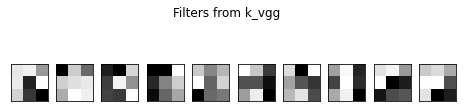

In [ ]:
import random

#visualise last conv layer of vgg of k folds
weight = last_vgg_model.conv3c.weight.detach().squeeze().cpu().numpy()
fig = plt.figure(num=1, figsize=(8,8))
fig.suptitle('Filters from k_vgg')
for filter in range(10):
  f = random.randint(0, 255)
  fig = plt.subplot(10, 10, filter + 1)
  fig.set_xticks([])
  fig.set_yticks([])
  plt.imshow(weight[0][f], cmap='gray')
  plt.show


##Visualising Feature Maps

We also visualise the feature maps so as to better understand the representations produced by the model. We dislay the feature map of a random mushroom using our best performing VGG model.

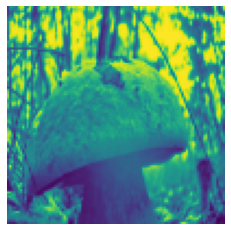

torch.Size([1, 1, 100, 100])


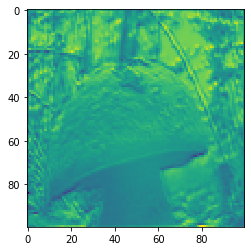

torch.Size([1, 25, 25])


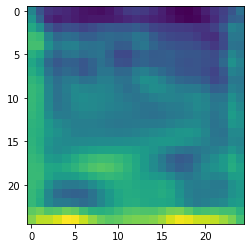

In [ ]:
#generate random image
mush_num = np.random.randint(0,900)
im = img_array3[mush_num]

#display image
plt.imshow((im/255.))
plt.axis("off")
plt.show()
im = torch.tensor(im).unsqueeze(0).unsqueeze(0)
im = im.cuda()
last_vgg_model.float().to(device)

arr = last_vgg_model.conv1a(im.float())
arr = torch.sum(arr, 1)
arr = arr.squeeze().cpu().detach().numpy()

#layer1 feature map
plt.imshow(arr, interpolation='nearest')
plt.show()

#show for conv3c
x = last_vgg_model.conv1a(im.float())
x = torch.relu(x)
x = last_vgg_model.conv1b(x)
x = torch.relu(x)
x = last_vgg_model.pool1(x)

x = last_vgg_model.conv2a(x)
x = torch.relu(x)
x = last_vgg_model.conv2b(x)
x = torch.relu(x)
x = last_vgg_model.pool2(x)

x = last_vgg_model.conv3a(x)
x = torch.relu(x)
x = last_vgg_model.conv3b(x)
x = torch.relu(x)
x = last_vgg_model.conv3c(x)

x = torch.sum(x, 1)
print(x.shape)
x = x.squeeze().cpu().detach().numpy()

#layer3 feature map
plt.imshow(x, interpolation='nearest')
plt.show()


We can see that on the last layer, although the general shape of the mushroom is still there, there are also some background noise.

##Random Testing

tensor([[ 189.3589, -190.5834]], grad_fn=<AddmmBackward0>)
tensor([[1., 0.]], grad_fn=<SoftmaxBackward0>)


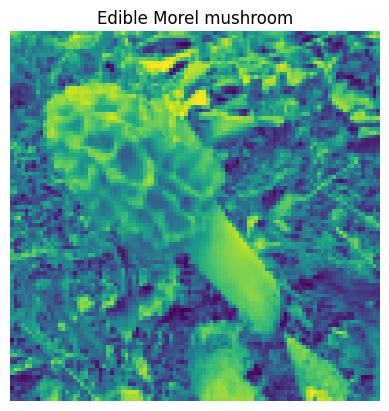

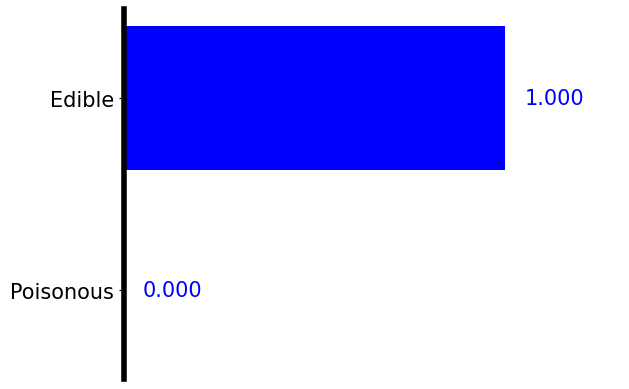

In [ ]:
import random

#load and show image
poison_indices = mushroom_labels["Poisonous"]
species_indices = mushroom_labels["Class"]

mush_num = np.random.randint(0,900)
mush_name = mushroom_labels[mushroom_labels.Class == species_indices.iloc[mush_num]].iloc[0].Mushroom
is_poisonous = poison_indices.iloc[mush_num]
labels = ['Edible', 'Poisonous']
im = img_array3[mush_num]
plt.imshow((im/255.))
plt.axis("off")
plt.title(labels[is_poisonous] + " " + mush_name)
model = last_vgg_model

#get probability
im = torch.tensor(im).unsqueeze(0).unsqueeze(0)
probs = torch.softmax(model(im.float().to(device)), 1)

#show probability
utils.show_prob_mush_mlp(probs)

#References




1. https://arxiv.org/abs/1411.6369

2. https://github.com/ohyicong/Google-Image-Scraper

3. https://www.selenium.dev/

4. https://whyfarmit.com/poisonous-mushrooms/ 

5. https://crushmag-online.com/guide-different-types-edible-mushrooms/

6. https://en.wikipedia.org/wiki/Edible_mushroom

7. https://scikit-image.org/docs/stable/api/skimage.exposure.html 


